In [3]:
from typing import Any
import random
import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import ToTensor

from validation_model import ValidationModel
from settings import *
from avapix.avapix_loss import AvapixLoss
from avapix.avapix_model import AvapixModel
import avapix.avapix_utils as utils

In [4]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [190]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, images, gen_per_image) -> None:
        super().__init__()

        self.transform = ToTensor()

        self.images = images.copy()
        self.gen_per_image = gen_per_image

        self.random_lengths = []
        self.curr_image_tensor = None

    def __getitem__(self, index) -> Any:
        if index % self.gen_per_image == 0:
            self.random_lengths = list(range(128))
            random.shuffle(self.random_lengths)

            curr_image = self.images[index // self.gen_per_image]
            self.curr_image_tensor = self.transform(
                Image.open(curr_image)).to(DEVICE)

        curr_rand_len = self.random_lengths.pop()

        output_img = utils.generate_input_v1(self.curr_image_tensor,
                                             DEFAULT_RANDOM_SEED,
                                             curr_rand_len)
        output_img = output_img.reshape((8, 8, 3)).permute((2, 0, 1))

        return output_img

    def __len__(self):
        return len(self.images) * self.gen_per_image


In [194]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils

In [195]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 5
GEN_PER_IMAGE = 16

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(image_list, GEN_PER_IMAGE)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss()
mse_loss = nn.MSELoss()

loss_model = ValidationModel(DEVICE)
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

In [196]:
losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for batch_imgs in dataloader:
        
        optimizer.zero_grad()
        outputs = model(batch_imgs)

        possibility_pred = loss_model(outputs)
        
        loss = criterion(possibility_pred)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}")
    # if epoch % 10 == 9:
    #     print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}", end='\t')
    #     if (epoch + 1) % 20 == 0:
    #         print()

print("Training complete.")

Epoch 001/5 - Loss: 4.2536
Epoch 002/5 - Loss: 0.0093
Epoch 003/5 - Loss: 0.0003
Epoch 004/5 - Loss: 0.0001
Epoch 005/5 - Loss: 0.0001
Training complete.


---

In [216]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
import validation_model
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
importlib.reload(validation_model)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils
from validation_model import ValidationModel

LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
GEN_PER_IMAGE = 10

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(image_list, GEN_PER_IMAGE)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss()
mse_loss = nn.MSELoss()

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

for batch_imgs in dataloader:
    outputs = model(batch_imgs)
    break

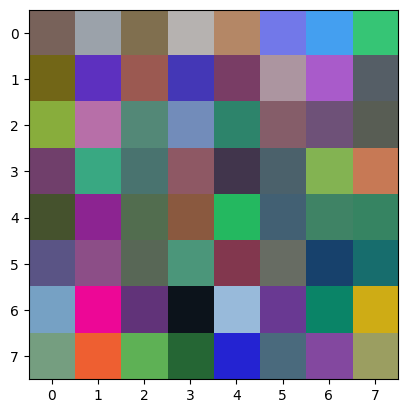

In [217]:
_ = outputs[30].detach().cpu().numpy().reshape((8,8,3))
plt.imshow(_)

In [219]:
loss_model(outputs[30].to(DEVICE).unsqueeze(0))

tensor([[0.0007]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: index 3 is out of bounds for axis 0 with size 3

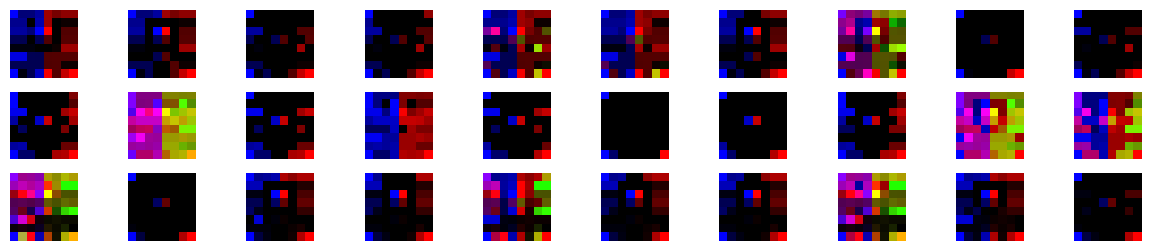

In [154]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(3, 10, figsize=(15, 3))

for batch_imgs in dataloader:
    for i, img in enumerate(batch_imgs):
        img = img.detach().cpu().numpy().reshape((8,8,3))
        axs[i // 10, i % 10].imshow(img)
        axs[i // 10, i % 10].axis('off')
    break

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


---

In [205]:
_ = utils.embed_raw_img_v1('Hello World!', 42).to(DEVICE) / 255
_ = _.reshape((3, 8, 8))
_ = _.unsqueeze(0)

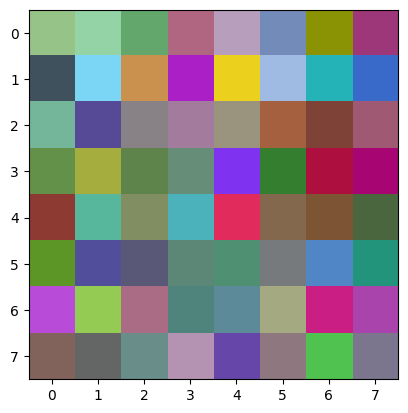

In [208]:
i_ = model(_)
plt.imshow(i_.detach().cpu().numpy().reshape((8, 8, 3)))

In [209]:
loss_model(i_)

tensor([[0.0058]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [167]:
_ = np.random.randint(0, 256, (8, 8, 3))
_[0, 0, 2] = 10000